#### This is part 3 in the Topic Modelling series
- Look forward to topic model building using Latent Dirichlet Allocation (LDA) from gensim

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils,models
from nltk import word_tokenize
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore")

C:\Users\pares\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
clean_data = pd.read_pickle("clean_data_lemmatized.pkl")

In [3]:
clean_data.info()
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395172 entries, 0 to 395171
Data columns (total 3 columns):
id        395172 non-null int64
title     395172 non-null object
review    395172 non-null object
dtypes: int64(1), object(2)
memory usage: 9.0+ MB


,id,title,review
0,0,Good Quality Dog Food,buy vitality can dog food product good quality...
1,1,Not as Advertised,product arrive label jumbo salt peanut peanut...
2,2,"""Delight"" says it all",confection century light pillowy citrus gela...
3,3,Cough Medicine,secret ingredient robitussin addition root be...
4,4,Great taffy,great taffy great price wide assortment yummy...


Now, we have an idea of the kind of topics or themes,we can hope to get, we can start our modelling process. In this project, I'll start with the famous LDA algorithm, and also look at LDAmallet and NMF. If I do not get satisfactory results, I'll also extend my search for good topics with HDP and LSI algorithms.

In [5]:
training,testing = np.split(clean_data,[int(.7*len(clean_data))])
testing.reset_index(drop=True,inplace = True)

In [6]:
len(training)

276620

###  Stopwords

- We have already removed the standard stop-words from our reviews. With respect to domain specific stop-words, I will remove them iteratively as and when I encounter them in our initial topic models. We observed through k-means a few domain specific stop-words, which I'll remove first and then take it from there.

In [8]:
#updated stop-words
stop_words = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","different","do","does","doing","done","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","have","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","it","itd","its","itself","j","just","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","shes","should","show","showed","shown","showns","shows","significant","significantly",
               "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure","t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","thats","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","thereof","therere","theres","thereto","thereupon","these","they","theyd","theyre","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","went","were","werent","we've","what","whatever","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","your","youre","yours","yourself","yourselves","z","zero"]

#adding term "perfect" noticed previously
domain1 = ["taste","excellent","love","nice","better","wonderful","stuff","delicious","yummy","tasty","favorite","product",
          "flavor","better","best","great","good","pretty","pleasant","surprise","decent","tasting","quality","buy","will",
          "yum","omg","tastes","market","special","service","shipping","easy","perfect","shipment","shipped"]

stop_words.extend(domain1) 

# Latent Dirichlet Allocation (LDA)

With LDA, we do not obtain disjoint sets. LDA's approach to topic modelling is, that it assumes each document as a collection of topics in a certain proportion, and each topic as a collection of keywords (in certain proportion). 
- With LDA, we can use the CoherenceModel algorithm to obtain Coherence scores to evaluate our model, and obtain the "right" number of topics.
- Also, we can use pyLDAvis library to visualize our topics, and better understand the results.
- Therefore, we will use topic visualization and coherence scores to evaluate how good are our topic models.

### LDA Attempt #1 (Using all text)

In [9]:
#preparing document-term matrix
docs = list(training.review)
vec = CountVectorizer(lowercase = True, stop_words = stop_words,ngram_range = (1,3),max_features = 5000)
X = vec.fit_transform(docs)

In [10]:
#we can directly convert our scipy_sparse_matrix 'X' into genism corpus using matutils
corpus = matutils.Sparse2Corpus(X.T)

In [11]:
#id2word is a dictionary containing all terms(mapped to a code) and their locations(indexes) in term-document matrix
id2word = dict([(k,v) for k,v in enumerate(vec.get_feature_names())])

In [14]:
#Lets save our corpus in "mm" format as it can be processed faster
#corpora.MmCorpus.serialize('all_text_corpus.mm',corpus)

In [13]:
corpusmm = corpora.MmCorpus('all_text_corpus.mm')

Since, we are dealing with a big dataset, I need to efficiently manage building the LDA model. For this, I am using LDA multicore and giving a mm formatted corpus and not calculating persplexity while building the model. Also, passes is set to low, since all these parameters affect time required to build the model.

#### Firstly, we need to get rid of all the domain specific stop-words that might have crept in our dictionary. For that, lets build a model, and identify important stop-words that we can get rid of. 

In [15]:
#LdA with 15 topics (observed 15 topics before with k-means)
lda = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 15,passes=2,eval_every = None)
lda.print_topics()

[(0,
  '0.030*"sauce" + 0.017*"add" + 0.016*"soup" + 0.015*"hot" + 0.015*"cook" + 0.012*"chicken" + 0.011*"rice" + 0.009*"food" + 0.009*"water" + 0.009*"pasta"'),
 (1,
  '0.028*"coconut" + 0.025*"cereal" + 0.023*"fruit" + 0.021*"peanut" + 0.020*"butter" + 0.018*"juice" + 0.015*"sweet" + 0.014*"honey" + 0.014*"water" + 0.012*"eat"'),
 (2,
  '0.035*"sugar" + 0.023*"calorie" + 0.021*"low" + 0.020*"fat" + 0.020*"protein" + 0.018*"ingredient" + 0.016*"healthy" + 0.015*"high" + 0.012*"diet" + 0.012*"eat"'),
 (3,
  '0.064*"store" + 0.049*"find" + 0.049*"amazon" + 0.027*"local" + 0.024*"price" + 0.023*"grocery" + 0.019*"year" + 0.018*"grocery store" + 0.016*"order" + 0.012*"carry"'),
 (4,
  '0.100*"chocolate" + 0.050*"cookie" + 0.034*"bar" + 0.019*"sweet" + 0.018*"dark" + 0.014*"cocoa" + 0.013*"milk" + 0.013*"eat" + 0.011*"cream" + 0.011*"dark chocolate"'),
 (5,
  '0.055*"order" + 0.039*"box" + 0.036*"bag" + 0.017*"arrive" + 0.016*"receive" + 0.015*"time" + 0.015*"package" + 0.015*"amazon" + 0

In [16]:
#there a lot of non-essential words that we need to get rid of
domain2 = ["store","find","amazon","order","item","arrive","receive","package","open","pack","packet","box","food","review",
           "eat","well","recommend","highly","help","purchase","money","price","cost","free","pay","payment","list","feel",
          "subscribe","thing","sell","top","recommendation"]
stop_words.extend(domain2)

In [17]:
#preparing new doc-term matrix with additional stop-words
docs = list(training.review)
vec = CountVectorizer(lowercase = True, stop_words = stop_words,ngram_range = (1,3),max_features = 5000)
X = vec.fit_transform(docs)

In [21]:
corpus = matutils.Sparse2Corpus(X.T)
id2word = dict([(k,v) for k,v in enumerate(vec.get_feature_names())])

In [22]:
#corpora.MmCorpus.serialize('all_text_corpus.mm',corpus)

In [23]:
corpusmm = corpora.MmCorpus('all_text_corpus.mm')

In [24]:
#LdA with 15 topics
lda = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 15,passes=2,eval_every = None)
lda.print_topics()

[(0,
  '0.051*"chocolate" + 0.026*"milk" + 0.026*"mix" + 0.020*"cereal" + 0.015*"bread" + 0.015*"gluten" + 0.010*"vanilla" + 0.010*"sweet" + 0.010*"add" + 0.009*"flour"'),
 (1,
  '0.024*"local" + 0.022*"time" + 0.021*"day" + 0.018*"work" + 0.014*"grocery" + 0.014*"energy" + 0.013*"carry" + 0.013*"long" + 0.012*"year" + 0.010*"drink"'),
 (2,
  '0.027*"snack" + 0.025*"bag" + 0.020*"size" + 0.019*"small" + 0.014*"container" + 0.013*"large" + 0.011*"plastic" + 0.011*"fresh" + 0.011*"packaging" + 0.009*"wrap"'),
 (3,
  '0.027*"salt" + 0.025*"oil" + 0.024*"hot" + 0.020*"sauce" + 0.016*"chip" + 0.014*"hair" + 0.013*"coconut" + 0.012*"popcorn" + 0.012*"pepper" + 0.010*"spicy"'),
 (4,
  '0.130*"coffee" + 0.046*"cup" + 0.012*"roast" + 0.011*"strong" + 0.011*"drink" + 0.010*"brew" + 0.010*"bean" + 0.010*"blend" + 0.009*"pod" + 0.008*"espresso"'),
 (5,
  '0.043*"cookie" + 0.026*"cracker" + 0.023*"gift" + 0.019*"time" + 0.015*"day" + 0.014*"friend" + 0.011*"family" + 0.011*"year" + 0.009*"enjoy" + 

#### Now, that we have removed those stop-words, lets understand the optimal number of topics using coherence metrics. We'll use "umass" since it takes less time to compute.

In [25]:
#building multiple models to short list number of topics based on coherence scores - we observed previously a range of 10-25 
#topics with k-means, therefore, lets look at the range more closely
c_score = []
for topic in range(10,40,4):
    lda_model = models.LdaMulticore(corpus = corpusmm,id2word = id2word, num_topics = topic,eval_every = None,passes=3)
    umass_metric = CoherenceModel(model = lda_model,corpus = corpus,coherence = "u_mass")
    c_score.append(umass_metric.get_coherence())

In [26]:
topics = range(10,40,4)

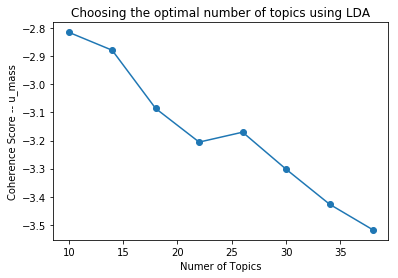

In [27]:
#umass-graph
plt.figure()
plt.plot(topics,c_score,marker = "o")
plt.xlabel("Numer of Topics")
plt.ylabel("Coherence Score -- u_mass")
plt.title("Choosing the optimal number of topics using LDA") 
plt.show()

#### Looking at the graph, we can say our best bet would be around 18-26 number of topics, thats where the curve is flattening. We also observed a range of 5-25 number of topics with k-means previously.

#### As far as number of topics go, lets look for something within this range.

In [28]:
#LdA with 10 topics
lda10 = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 10,passes=3,eval_every = None)
lda10.print_topics()

[(0,
  '0.030*"sauce" + 0.017*"hot" + 0.014*"soup" + 0.012*"baby" + 0.011*"add" + 0.011*"cheese" + 0.010*"chicken" + 0.010*"spicy" + 0.009*"spice" + 0.009*"pepper"'),
 (1,
  '0.032*"oil" + 0.017*"cook" + 0.015*"rice" + 0.014*"pasta" + 0.013*"hair" + 0.013*"bread" + 0.011*"coconut" + 0.011*"noodle" + 0.010*"olive" + 0.010*"water"'),
 (2,
  '0.037*"mix" + 0.019*"sugar" + 0.019*"water" + 0.017*"add" + 0.013*"powder" + 0.012*"cake" + 0.012*"flour" + 0.012*"recipe" + 0.010*"milk" + 0.010*"coconut"'),
 (3,
  '0.111*"tea" + 0.041*"drink" + 0.023*"water" + 0.016*"green" + 0.011*"green tea" + 0.009*"juice" + 0.008*"bag" + 0.007*"hot" + 0.007*"cup" + 0.007*"day"'),
 (4,
  '0.118*"coffee" + 0.045*"cup" + 0.012*"bean" + 0.011*"roast" + 0.010*"strong" + 0.010*"drink" + 0.010*"blend" + 0.009*"espresso" + 0.009*"brew" + 0.008*"dark"'),
 (5,
  '0.035*"cookie" + 0.030*"bag" + 0.019*"chip" + 0.019*"cracker" + 0.018*"local" + 0.015*"snack" + 0.015*"grocery" + 0.013*"year" + 0.010*"chocolate" + 0.009*"glu

Here, we do have come clearly visible topics. We have topics related to:
- cereals, types of tea(s), juices, types of coffee, items required to make coffee, dog treats. Rest of the topics aren't that coherent.

In [29]:
#gensim dictionary required for input
dct = Dictionary.from_corpus(corpusmm,id2word = id2word)
vis = pyLDAvis.gensim.prepare(lda10,corpusmm,dictionary = dct,sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.014605  0.095335       1        1   9.126347
1      0.031786  0.124477       2        1   7.937977
2     -0.088952  0.165410       3        1   8.350075
3     -0.186981 -0.044625       4        1  10.311510
4     -0.195715 -0.177311       5        1   9.709394
5      0.139720 -0.093821       6        1   8.549598
6      0.107521 -0.104833       7        1  15.131860
7     -0.009067  0.119747       8        1  11.793283
8      0.162273 -0.044540       9        1  12.087986
9      0.024808 -0.039839      10        1   7.001966, topic_info=     Category          Freq         Term         Total  loglift  logprob
911   Default  74177.000000       coffee  74177.000000  30.0000  30.0000
4427  Default  73853.000000          tea  73853.000000  29.0000  29.0000
1411  Default  40805.000000          dog  40805.000000  28.0000  28.0000
1185  Default  37381.000000          cup  37381.000000  27.0000  27.0000
1469  Default  36524.000000        drink  36524.000000  26.0000  26.0000
806   Default  34006.000000    chocolate  34006.000000  25.0000  25.0000
1083  Default  19332.000000       cookie  19332.000000  24.0000  24.0000
683   Default  22054.000000          cat  22054.000000  23.0000  23.0000
2901  Default  28497.000000          mix  28497.000000  22.0000  22.0000
3806  Default  18396.000000        sauce  18396.000000  21.0000  21.0000
3091  Default  17863.000000          oil  17863.000000  20.0000  20.0000
639   Default  14377.000000        candy  14377.000000  19.0000  19.0000
301   Default  17500.000000          bar  17500.000000  18.0000  18.0000
4644  Default  26075.000000        treat  26075.000000  17.0000  17.0000
4835  Default  34308.000000        water  34308.000000  16.0000  16.0000
253   Default  38114.000000          bag  38114.000000  15.0000  15.0000
4284  Default  31100.000000        sugar  31100.000000  14.0000  14.0000
709   Default  13025.000000       cereal  13025.000000  13.0000  13.0000
797   Default  10568.000000         chip  10568.000000  12.0000  12.0000
4354  Default  27491.000000        sweet  27491.000000  11.0000  11.0000
1133  Default  10392.000000      cracker  10392.000000  10.0000  10.0000
4051  Default  18594.000000        snack  18594.000000   9.0000   9.0000
2863  Default  20079.000000         milk  20079.000000   8.0000   8.0000
1077  Default  11562.000000         cook  11562.000000   7.0000   7.0000
2074  Default  15872.000000        green  15872.000000   6.0000   6.0000
28    Default  25737.000000          add  25737.000000   5.0000   5.0000
2259  Default  10514.000000        honey  10514.000000   4.0000   4.0000
2276  Default  20515.000000          hot  20515.000000   3.0000   3.0000
3230  Default   9313.000000       peanut   9313.000000   2.0000   2.0000
2659  Default  14642.000000        local  14642.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
3015  Topic10    758.251160       newton    797.694946   2.6083  -6.3906
2259  Topic10   7801.453125        honey  10514.458984   2.3605  -4.0596
2768  Topic10   1077.772949  maple syrup   1175.584961   2.5721  -6.0390
4409  Topic10   1910.471680         tart   2236.155518   2.5016  -5.4665
171   Topic10   4294.492676        apple   5642.621094   2.3860  -4.6565
1580  Topic10   4516.750488       energy   6069.426758   2.3635  -4.6061
2767  Topic10   1838.956543        maple   2246.157227   2.4590  -5.5047
4237  Topic10   2870.674316   strawberry   3998.119141   2.3277  -5.0593
1915  Topic10   7261.487305        fruit  12433.958984   2.1211  -4.1313
2887  Topic10   2804.461914         mint   4165.823730   2.2633  -5.0826
656   Topic10   2132.313965      caramel   2994.260742   2.3195  -5.3567
4098  Topic10   2251.274902         sour   3337.946533   2.2651  -5.3024
4354  Topic10  10679.790039        sweet  27491.410156   1.7135  -3.7455
2952  Topic10   3305.959

In [30]:
#LdA with 15 topics
lda15 = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 15,passes=3,eval_every = None)
lda15.print_topics()

[(0,
  '0.136*"tea" + 0.038*"drink" + 0.034*"water" + 0.019*"green" + 0.013*"green tea" + 0.009*"cup" + 0.008*"ginger" + 0.008*"bag" + 0.007*"hot" + 0.007*"ice"'),
 (1,
  '0.049*"sauce" + 0.039*"hot" + 0.021*"spicy" + 0.017*"pepper" + 0.015*"friend" + 0.012*"jerky" + 0.011*"heat" + 0.011*"family" + 0.010*"hot sauce" + 0.010*"spice"'),
 (2,
  '0.059*"sugar" + 0.019*"juice" + 0.018*"syrup" + 0.018*"ingredient" + 0.018*"drink" + 0.017*"sweet" + 0.016*"fruit" + 0.014*"natural" + 0.011*"soda" + 0.011*"artificial"'),
 (3,
  '0.030*"time" + 0.025*"local" + 0.023*"year" + 0.019*"grocery" + 0.012*"ship" + 0.011*"cheap" + 0.011*"ago" + 0.011*"carry" + 0.011*"month" + 0.011*"long"'),
 (4,
  '0.072*"dog" + 0.040*"cat" + 0.038*"treat" + 0.010*"feed" + 0.010*"dry" + 0.009*"pet" + 0.008*"ingredient" + 0.008*"year" + 0.008*"chew" + 0.008*"chicken"'),
 (5,
  '0.052*"organic" + 0.033*"baby" + 0.025*"rice" + 0.024*"honey" + 0.018*"oatmeal" + 0.015*"son" + 0.012*"healthy" + 0.012*"brown" + 0.011*"daughter

Here, we can see, we have topics related to:
- Hot drinks, Beverages, Dogs, Recipe, Coffee, Cereal, High Energy product, Types of tea(s), Snacks

In [31]:
vis = pyLDAvis.gensim.prepare(lda15,corpusmm,dictionary = dct,sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.210372 -0.029000       1        1   7.976594
1      0.018601 -0.087428       2        1   4.166616
2      0.070842  0.172192       3        1   7.117957
3     -0.112401 -0.179613       4        1   8.146564
4     -0.178218  0.021889       5        1   8.845201
5     -0.107881  0.095284       6        1   4.453361
6     -0.083277 -0.095960       7        1  10.673900
7     -0.033768 -0.058287       8        1   6.228697
8      0.183718 -0.103294       9        1   8.611492
9      0.027177 -0.014204      10        1   7.621732
10     0.212738  0.055604      11        1   5.224564
11    -0.052327  0.025501      12        1   4.949153
12    -0.059995  0.146949      13        1   5.512787
13    -0.046745 -0.141179      14        1   4.768685
14    -0.048835  0.191544      15        1   5.702693, topic_info=     Category          Freq         Term         Total  loglift  logprob
911   Default  74137.000000       coffee  74137.000000  30.0000  30.0000
4427  Default  70133.000000          tea  70133.000000  29.0000  29.0000
1411  Default  41432.000000          dog  41432.000000  28.0000  28.0000
806   Default  34141.000000    chocolate  34141.000000  27.0000  27.0000
253   Default  37005.000000          bag  37005.000000  26.0000  26.0000
4284  Default  32501.000000        sugar  32501.000000  25.0000  25.0000
683   Default  22723.000000          cat  22723.000000  24.0000  24.0000
301   Default  18881.000000          bar  18881.000000  23.0000  23.0000
1185  Default  36967.000000          cup  36967.000000  22.0000  22.0000
1083  Default  18832.000000       cookie  18832.000000  21.0000  21.0000
3806  Default  18899.000000        sauce  18899.000000  20.0000  20.0000
1469  Default  36167.000000        drink  36167.000000  19.0000  19.0000
2863  Default  19896.000000         milk  19896.000000  18.0000  18.0000
2901  Default  28531.000000          mix  28531.000000  17.0000  17.0000
3123  Default  16739.000000      organic  16739.000000  16.0000  16.0000
4644  Default  26262.000000        treat  26262.000000  15.0000  15.0000
2276  Default  20839.000000          hot  20839.000000  14.0000  14.0000
4835  Default  33410.000000        water  33410.000000  13.0000  13.0000
3777  Default  14000.000000         salt  14000.000000  12.0000  12.0000
2706  Default  15534.000000          low  15534.000000  11.0000  11.0000
709   Default  12996.000000       cereal  12996.000000  10.0000  10.0000
2005  Default  11729.000000       gluten  11729.000000   9.0000   9.0000
243   Default   9602.000000         baby   9602.000000   8.0000   8.0000
1730  Default  11053.000000          fat  11053.000000   7.0000   7.0000
2659  Default  13750.000000        local  13750.000000   6.0000   6.0000
639   Default  14331.000000        candy  14331.000000   5.0000   5.0000
3230  Default   9815.000000       peanut   9815.000000   4.0000   4.0000
3683  Default  11594.000000         rice  11594.000000   3.0000   3.0000
618   Default  14269.000000      calorie  14269.000000   2.0000   2.0000
588   Default  12283.000000       butter  12283.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
3868  Topic15   5416.836426         seed   6015.759277   2.7594  -4.2191
657   Topic15   4623.736328         carb   5152.871582   2.7559  -4.3774
3097  Topic15    831.900574        omega    862.471191   2.8281  -6.0926
2710  Topic15   1904.022949  low calorie   2063.727295   2.7837  -5.2646
1821  Topic15   1499.408691         flax   1605.515137   2.7959  -5.5035
4070  Topic15   4371.763672       sodium   5036.632324   2.7227  -4.4334
2706  Topic15  12034.538086          low  15534.365234   2.6090  -3.4208
3452  Topic15   8675.554688      protein  11151.453125   2.6132  -3.7481
2462  Topic15   1601.516235        jelly   1774.704590   2.7615  -5.4376
3777  Topic15  10147.408203         salt  1400

In [32]:
#LdA with 20 topics
lda20 = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 20,passes=3,eval_every = None)
lda20.print_topics()

[(0,
  '0.211*"tea" + 0.028*"green" + 0.020*"green tea" + 0.015*"bag" + 0.013*"cup" + 0.013*"drink" + 0.010*"black" + 0.009*"tea bag" + 0.009*"strong" + 0.008*"brew"'),
 (1,
  '0.071*"sugar" + 0.029*"calorie" + 0.027*"low" + 0.025*"cereal" + 0.024*"fat" + 0.021*"honey" + 0.021*"protein" + 0.014*"high" + 0.013*"fiber" + 0.013*"carb"'),
 (2,
  '0.051*"drink" + 0.032*"juice" + 0.031*"ice" + 0.023*"soda" + 0.022*"cream" + 0.019*"sweet" + 0.014*"sugar" + 0.014*"water" + 0.013*"orange" + 0.012*"blend"'),
 (3,
  '0.031*"gift" + 0.027*"salt" + 0.023*"candy" + 0.018*"ginger" + 0.014*"lemon" + 0.013*"cherry" + 0.013*"dry" + 0.010*"color" + 0.009*"white" + 0.009*"lime"'),
 (4,
  '0.068*"water" + 0.062*"oil" + 0.044*"coconut" + 0.023*"bottle" + 0.017*"olive" + 0.015*"coconut oil" + 0.011*"health" + 0.010*"benefit" + 0.010*"olive oil" + 0.009*"brand"'),
 (5,
  '0.059*"time" + 0.025*"long" + 0.022*"gum" + 0.017*"candy" + 0.015*"day" + 0.014*"chew" + 0.013*"cinnamon" + 0.013*"oatmeal" + 0.012*"hard" 

In [33]:
vis = pyLDAvis.gensim.prepare(lda20,corpusmm,dictionary = dct,sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.137467 -0.164319       1        1  5.216756
1     -0.147433  0.107282       2        1  5.809048
2     -0.238353 -0.080936       3        1  3.880829
3      0.027671  0.023322       4        1  4.015357
4     -0.082390 -0.089059       5        1  4.296032
5      0.139176  0.011746       6        1  4.254288
6      0.019095  0.134069       7        1  3.912525
7      0.179995 -0.030202       8        1  6.473058
8     -0.059108  0.076004       9        1  3.991707
9      0.028061 -0.150667      10        1  4.015110
10    -0.103808 -0.154073      11        1  7.926761
11    -0.141669  0.016502      12        1  4.479358
12    -0.058544  0.214879      13        1  4.771211
13     0.054375 -0.060519      14        1  2.932219
14     0.129110  0.020541      15        1  2.040990
15    -0.003900  0.173026      16        1  4.457209
16     0.133860  0.015004      17        1  8.668791
17    -0.048326  0.079704      18        1  6.277038
18     0.152926 -0.078923      19        1  6.385486
19     0.156732 -0.063383      20        1  6.196227, topic_info=     Category          Freq       Term         Total  loglift  logprob
4427  Default  70980.000000        tea  70980.000000  30.0000  30.0000
911   Default  73476.000000     coffee  73476.000000  29.0000  29.0000
1411  Default  40674.000000        dog  40674.000000  28.0000  28.0000
806   Default  33489.000000  chocolate  33489.000000  27.0000  27.0000
1469  Default  38939.000000      drink  38939.000000  26.0000  26.0000
253   Default  38386.000000        bag  38386.000000  25.0000  25.0000
4284  Default  31724.000000      sugar  31724.000000  24.0000  24.0000
301   Default  19132.000000        bar  19132.000000  23.0000  23.0000
4835  Default  33809.000000      water  33809.000000  22.0000  22.0000
1185  Default  36727.000000        cup  36727.000000  21.0000  21.0000
1083  Default  17860.000000     cookie  17860.000000  20.0000  20.0000
3091  Default  18362.000000        oil  18362.000000  19.0000  19.0000
683   Default  22399.000000        cat  22399.000000  18.0000  18.0000
2276  Default  20190.000000        hot  20190.000000  17.0000  17.0000
3806  Default  18756.000000      sauce  18756.000000  16.0000  16.0000
4051  Default  19479.000000      snack  19479.000000  15.0000  15.0000
3683  Default  12003.000000       rice  12003.000000  14.0000  14.0000
904   Default  12146.000000    coconut  12146.000000  13.0000  13.0000
2863  Default  19295.000000       milk  19295.000000  12.0000  12.0000
4551  Default  48450.000000       time  48450.000000  11.0000  11.0000
4644  Default  25823.000000      treat  25823.000000  10.0000  10.0000
2901  Default  28992.000000        mix  28992.000000   9.0000   9.0000
2659  Default  13836.000000      local  13836.000000   8.0000   8.0000
2005  Default  11820.000000     gluten  11820.000000   7.0000   7.0000
797   Default  10822.000000       chip  10822.000000   6.0000   6.0000
3230  Default   9906.000000     peanut   9906.000000   5.0000   5.0000
588   Default  12507.000000     butter  12507.000000   4.0000   4.0000
1253  Default  30930.000000        day  30930.000000   3.0000   3.0000
3989  Default  14389.000000       size  14389.000000   2.0000   2.0000
504   Default   9682.000000      bread   9682.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
4718  Topic20    991.778076       unit   1166.172974   2.6192  -5.9999
2455  Topic20   5143.347656        jar   8078.071289   2.3298  -4.3539
3319  Topic20   3711.048828    plastic   5815.014648   2.3321  -4.6803
4201  Topic20    922.631104    steamer   1123.433472   2.5843  -6.0722
4141  Topic20    593.428223      spill    667.865845   2.6631  -6.5135
1539  Topic20   1010.323364      earth   1298.532959   2.5303  -5.9814
3175  Topic20   3385.576416  packaging   6197.030273   2.1767  -4.7721
2253  Topic20    889.9

In [34]:
#LdA with 25 topics
lda25 = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 25,passes=3,eval_every = None)
lda25.print_topics()

[(6,
  '0.110*"dog" + 0.090*"treat" + 0.034*"chew" + 0.018*"small" + 0.016*"piece" + 0.014*"bone" + 0.013*"tooth" + 0.010*"size" + 0.010*"toy" + 0.009*"pill"'),
 (16,
  '0.066*"bottle" + 0.041*"honey" + 0.041*"jar" + 0.035*"oz" + 0.021*"ounce" + 0.018*"pouch" + 0.015*"salad" + 0.013*"glass" + 0.010*"dressing" + 0.009*"plastic"'),
 (12,
  '0.064*"sugar" + 0.059*"milk" + 0.038*"add" + 0.027*"powder" + 0.024*"mix" + 0.015*"sweetener" + 0.013*"water" + 0.012*"sweet" + 0.012*"cinnamon" + 0.011*"protein"'),
 (17,
  '0.153*"chocolate" + 0.029*"dark" + 0.025*"cream" + 0.022*"cocoa" + 0.020*"ice" + 0.017*"dark chocolate" + 0.017*"hot" + 0.015*"bar" + 0.014*"sweet" + 0.014*"mint"'),
 (1,
  '0.042*"roast" + 0.039*"blend" + 0.033*"organic" + 0.027*"variety" + 0.025*"mountain" + 0.025*"bold" + 0.024*"green" + 0.023*"french" + 0.020*"dark" + 0.017*"extra"'),
 (15,
  '0.034*"local" + 0.027*"grocery" + 0.026*"star" + 0.023*"cheap" + 0.016*"save" + 0.015*"deal" + 0.014*"expensive" + 0.013*"brand" + 0.0

In [35]:
vis = pyLDAvis.gensim.prepare(lda25,corpusmm,dictionary = dct,sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.139848 -0.149572       1        1  3.916003
1     -0.068348  0.259167       2        1  1.833752
2      0.105200  0.007092       3        1  3.272127
3      0.159138 -0.029471       4        1  4.106162
4     -0.052665 -0.094259       5        1  3.965623
5     -0.125677 -0.140158       6        1  5.176531
6      0.151511 -0.100409       7        1  4.393376
7     -0.074177  0.260570       8        1  5.606080
8      0.174190 -0.031328       9        1  6.400836
9     -0.057640 -0.101441      10        1  2.570930
10    -0.039376 -0.053202      11        1  2.647036
11    -0.087589 -0.005119      12        1  4.220170
12    -0.173803 -0.063464      13        1  4.231740
13     0.064576 -0.000413      14        1  2.645814
14     0.117475  0.018806      15        1  4.964729
15     0.173676  0.034393      16        1  4.580926
16     0.062289 -0.027057      17        1  2.525915
17    -0.117279  0.019771      18        1  3.263402
18     0.054451 -0.119973      19        1  5.592863
19    -0.102650  0.168489      20        1  4.685789
20     0.056396  0.172602      21        1  3.169119
21    -0.060611  0.038971      22        1  3.328954
22    -0.068696 -0.062624      23        1  5.609075
23     0.213771  0.017234      24        1  3.794675
24    -0.164314 -0.018606      25        1  3.498371, topic_info=     Category          Freq         Term         Total  loglift  logprob
4427  Default  70605.000000          tea  70605.000000  30.0000  30.0000
911   Default  74148.000000       coffee  74148.000000  29.0000  29.0000
806   Default  33529.000000    chocolate  33529.000000  28.0000  28.0000
1411  Default  41442.000000          dog  41442.000000  27.0000  27.0000
253   Default  36526.000000          bag  36526.000000  26.0000  26.0000
1185  Default  34080.000000          cup  34080.000000  25.0000  25.0000
1469  Default  37254.000000        drink  37254.000000  24.0000  24.0000
4644  Default  27511.000000        treat  27511.000000  23.0000  23.0000
1083  Default  19892.000000       cookie  19892.000000  22.0000  22.0000
4835  Default  34223.000000        water  34223.000000  21.0000  21.0000
3091  Default  20418.000000          oil  20418.000000  20.0000  20.0000
4284  Default  30606.000000        sugar  30606.000000  19.0000  19.0000
683   Default  20841.000000          cat  20841.000000  18.0000  18.0000
3806  Default  18252.000000        sauce  18252.000000  17.0000  17.0000
4051  Default  18505.000000        snack  18505.000000  16.0000  16.0000
2863  Default  18417.000000         milk  18417.000000  15.0000  15.0000
3777  Default  14407.000000         salt  14407.000000  14.0000  14.0000
904   Default  13721.000000      coconut  13721.000000  13.0000  13.0000
301   Default  17966.000000          bar  17966.000000  12.0000  12.0000
471   Default  15204.000000       bottle  15204.000000  11.0000  11.0000
588   Default  12474.000000       butter  12474.000000  10.0000  10.0000
2276  Default  20074.000000          hot  20074.000000   9.0000   9.0000
2901  Default  28020.000000          mix  28020.000000   8.0000   8.0000
1133  Default   9882.000000      cracker   9882.000000   7.0000   7.0000
3230  Default   9778.000000       peanut   9778.000000   6.0000   6.0000
709   Default  12707.000000       cereal  12707.000000   5.0000   5.0000
2005  Default  11262.000000       gluten  11262.000000   4.0000   4.0000
2074  Default  15263.000000        green  15263.000000   3.0000   3.0000
639   Default  13243.000000        candy  13243.000000   2.0000   2.0000
28    Default  25199.000000          add  25199.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
171   Topic25   4929.689941        apple   5816.448242   3.1875  -3.8231
362   Topic25   2976.978027        berry   3447.169434   3.2062  -4.3274
2603  Topic25   4628.240723        lemon   5

From the above results, we were able to summarize the topics in particular themes. That means, we dont need to change our document-term matrix (we have good terms there). As far as number of topics go, looks like 25 topics seem to consist a few completely overlapping topics. Our optimal number of topics should be somewhere between 15-20 topics.

- Lets calculate coherent scores for all models between that range to finalize on our model.

In [36]:
c_score2 = []
for topic in range(15,21,1):
    lda_model = models.LdaMulticore(corpus = corpusmm,id2word = id2word, num_topics = topic,eval_every = None,passes=3)
    umass_metric = CoherenceModel(model = lda_model,corpus = corpus,coherence = "u_mass")
    c_score2.append(umass_metric.get_coherence())

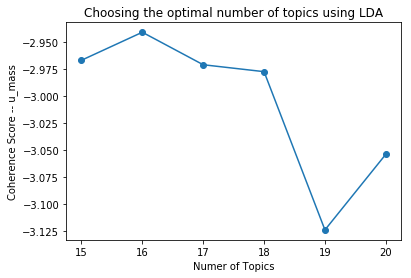

In [37]:
topics = range(15,21,1)
#umass-graph
plt.figure()
plt.plot(topics,c_score2,marker = "o")
plt.xlabel("Numer of Topics")
plt.ylabel("Coherence Score -- u_mass")
plt.title("Choosing the optimal number of topics using LDA") 
plt.show()

From these models, one with 16 number of topics gives us the least coherence score. Lets train this model further with high number of passes to get better topics.

## Final LDA model

In [38]:
#LdA with 16 topics
lda16_more_passes = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 16,passes=100,eval_every = None)
lda16_more_passes.print_topics()

[(0,
  '0.026*"local" + 0.025*"time" + 0.025*"year" + 0.019*"grocery" + 0.013*"month" + 0.012*"ship" + 0.012*"day" + 0.012*"ago" + 0.011*"brand" + 0.011*"carry"'),
 (1,
  '0.037*"bar" + 0.035*"cereal" + 0.024*"honey" + 0.023*"protein" + 0.018*"oatmeal" + 0.017*"seed" + 0.016*"sugar" + 0.015*"nut" + 0.015*"breakfast" + 0.015*"almond"'),
 (2,
  '0.080*"treat" + 0.067*"dog" + 0.034*"chew" + 0.030*"gum" + 0.020*"piece" + 0.017*"tooth" + 0.016*"small" + 0.013*"time" + 0.012*"bone" + 0.010*"long"'),
 (3,
  '0.027*"bad" + 0.019*"star" + 0.012*"read" + 0.011*"time" + 0.010*"smell" + 0.009*"people" + 0.008*"reviewer" + 0.007*"work" + 0.007*"jerky" + 0.007*"throw"'),
 (4,
  '0.054*"drink" + 0.045*"water" + 0.031*"sugar" + 0.025*"bottle" + 0.013*"sweet" + 0.011*"mix" + 0.010*"ginger" + 0.010*"syrup" + 0.010*"add" + 0.009*"energy"'),
 (5,
  '0.059*"bag" + 0.022*"small" + 0.019*"size" + 0.018*"large" + 0.014*"container" + 0.013*"time" + 0.013*"plastic" + 0.012*"oz" + 0.011*"packaging" + 0.011*"fres

In [39]:
vis = pyLDAvis.gensim.prepare(lda16_more_passes,corpusmm,dictionary = dct,sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.175559 -0.085910       1        1  8.439967
1     -0.115767  0.186020       2        1  5.229682
2      0.218881 -0.006156       3        1  4.791136
3      0.151725 -0.011681       4        1  8.110719
4     -0.082683  0.033451       5        1  7.533041
5      0.157288  0.000717       6        1  7.286834
6     -0.179809 -0.074371       7        1  4.949888
7     -0.121864  0.224422       8        1  5.096193
8      0.041847 -0.194435       9        1  4.314794
9     -0.107245 -0.027756      10        1  9.192727
10    -0.058617 -0.044894      11        1  4.654877
11     0.155806  0.149390      12        1  5.954285
12    -0.157139 -0.119617      13        1  5.868019
13    -0.054271  0.117898      14        1  6.167536
14     0.101997  0.020779      15        1  4.386582
15    -0.125709 -0.167856      16        1  8.023717, topic_info=     Category          Freq         Term         Total  loglift  logprob
4427  Default  70645.000000          tea  70645.000000  30.0000  30.0000
911   Default  74968.000000       coffee  74968.000000  29.0000  29.0000
806   Default  33918.000000    chocolate  33918.000000  28.0000  28.0000
1411  Default  41150.000000          dog  41150.000000  27.0000  27.0000
4644  Default  26172.000000        treat  26172.000000  26.0000  26.0000
1469  Default  37127.000000        drink  37127.000000  25.0000  25.0000
253   Default  37293.000000          bag  37293.000000  24.0000  24.0000
683   Default  19794.000000          cat  19794.000000  23.0000  23.0000
1185  Default  37217.000000          cup  37217.000000  22.0000  22.0000
4051  Default  19419.000000        snack  19419.000000  21.0000  21.0000
1083  Default  19771.000000       cookie  19771.000000  20.0000  20.0000
2863  Default  19362.000000         milk  19362.000000  19.0000  19.0000
2901  Default  28723.000000          mix  28723.000000  18.0000  18.0000
4835  Default  32854.000000        water  32854.000000  17.0000  17.0000
301   Default  18009.000000          bar  18009.000000  16.0000  16.0000
904   Default  13344.000000      coconut  13344.000000  15.0000  15.0000
3806  Default  17433.000000        sauce  17433.000000  14.0000  14.0000
4284  Default  31759.000000        sugar  31759.000000  13.0000  13.0000
3123  Default  19479.000000      organic  19479.000000  12.0000  12.0000
639   Default  14074.000000        candy  14074.000000  11.0000  11.0000
3091  Default  19156.000000          oil  19156.000000  10.0000  10.0000
2005  Default  11711.000000       gluten  11711.000000   9.0000   9.0000
2385  Default  20467.000000   ingredient  20467.000000   8.0000   8.0000
709   Default  11764.000000       cereal  11764.000000   7.0000   7.0000
2659  Default  13977.000000        local  13977.000000   6.0000   6.0000
1915  Default  12899.000000        fruit  12899.000000   5.0000   5.0000
618   Default  14406.000000      calorie  14406.000000   4.0000   4.0000
762   Default  10431.000000         chew  10431.000000   3.0000   3.0000
588   Default  11665.000000       butter  11665.000000   2.0000   2.0000
4095  Default  12730.000000         soup  12730.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
528   Topic16    845.652039  brew coffee    846.602844   2.5216  -6.4189
2538  Topic16    836.206543         kona    837.157349   2.5216  -6.4301
4182  Topic16   4765.566406     starbuck   4968.698242   2.4810  -4.6898
3719  Topic16   6829.520508        roast   7582.562988   2.4182  -4.3300
1146  Topic16   1861.152710      creamer   1965.870483   2.4680  -5.6300
1185  Topic16  27745.037109          cup  37217.695312   2.2290  -2.9282
2949  Topic16   2606.093506     mountain   2851.099121   2.4329  -5.2934
452   Topic16   3561.648926         bold   4015.147705   2.4029  -4.9810
532   Topic16   1421.713013       brewer   1503.812500   2.4666  -5.8994
1883  Topi

So, we have got 16 topics which can be described as follows:
    1. Delivery related issues
    2. Breakfast Food
    3. Chewing gums/ Dog Treats
    4. Bad products
    5. Energy Drinks/Sports Drinks
    6. Packaging
    7. Sweet Snacks (Chocolates)
    8. Beverages (Juices)
    9. Gifts
    10. Spicy Food 
    11. A Baking Recipe
    12. Pet Issues
    13. Tea(s)
    14. Salty Snacks (Crackers)
    15. Hair Products/ Cat Issues
    16. Coffee

Some of these topics are closely related, for example - coffee and tea(s). They both are beverages, so makes sense. Also, cat food and dog food and dog treats are very closely related, as all are Animal Food. 

In [40]:
tokenize_docs = list(map(word_tokenize,docs))

In [50]:
#what is this model's coherence score?
cv_metric = CoherenceModel(model = lda16_more_passes,corpus = corpusmm,dictionary = dct,coherence = "u_mass")
cv_metric.get_coherence()

-2.935041187254539

## Finding the most dominant topic in each review

In [52]:
docs_with_topics = pd.DataFrame(columns = ["document_ID","dominant_topic","perc_topic","keywords","review"])
docs_with_topics["document_ID"] = training.id
docs_with_topics["review"] = training.review

In [53]:
for i in range(len(corpusmm)):
    topic,topic_perc = sorted(lda16_more_passes[corpusmm[i]],key = lambda x:x[1],reverse = True)[0]
    topic_keywords = ', '.join([word for word,word_perc in lda16_more_passes.show_topic(topic)])
    doc_topic_dist = pd.Series([topic,topic_perc,topic_keywords])
    docs_with_topics.at[i,"dominant_topic"],docs_with_topics.at[i,"perc_topic"],docs_with_topics.at[i,"keywords"] = doc_topic_dist

In [54]:
docs_with_topics.head(10)

,document_ID,dominant_topic,perc_topic,keywords,review
0,0,11,0.665079,"dog, feed, ingredient, year, dry, chicken, die...",buy vitality can dog food product good quality...
1,1,8,0.342128,"candy, butter, peanut, friend, gift, family, k...",product arrive label jumbo salt peanut peanut...
2,2,6,0.448363,"chocolate, milk, vanilla, dark, cream, popcorn...",confection century light pillowy citrus gela...
3,3,4,0.640048,"drink, water, sugar, bottle, sweet, mix, ginge...",secret ingredient robitussin addition root be...
4,4,0,0.365135,"local, time, year, grocery, month, ship, day, ...",great taffy great price wide assortment yummy...
5,5,4,0.241855,"drink, water, sugar, bottle, sweet, mix, ginge...",wild hair taffy order pound bag taffy enjoyab...
6,6,5,0.290209,"bag, small, size, large, container, time, plas...",saltwater taffy great flavor soft chewy candy...
7,7,13,0.751719,"snack, cookie, calorie, chip, fat, cracker, lo...",taffy good soft chewy flavor amazing defini...
8,8,14,0.484757,"cat, coconut, oil, baby, hair, smell, coconut ...",sprout cat eat grass love rotate wheatgrass rye
9,9,11,0.914773,"dog, feed, ingredient, year, dry, chicken, die...",healthy dog food good digestion good small p...


So now, since we know whats the most dominant topic is for each document, lets look at some insights.

## Document Distribution for each topic

In [55]:
topic_distribution = pd.DataFrame(columns = ["topic_no","topic_keywords","total_documents","perc_docs"])
topic_distribution.topic_no = range(15)
for i in range(15):
    topic_distribution.at[i,"topic_keywords"] = ', '.join([word for word,perc in lda16_more_passes.show_topic(i)])
topic_distribution.total_documents = docs_with_topics.dominant_topic.value_counts().sort_index()
topic_distribution.perc_docs = (topic_distribution.total_documents/topic_distribution.total_documents.sum())*100
topic_distribution

,topic_no,topic_keywords,total_documents,perc_docs
0,0,"local, time, year, grocery, month, ship, day, ...",29932,11.946708
1,1,"bar, cereal, honey, protein, oatmeal, seed, su...",13717,5.474843
2,2,"treat, dog, chew, gum, piece, tooth, small, ti...",15628,6.237577
3,3,"bad, star, read, time, smell, people, reviewer...",17197,6.863809
4,4,"drink, water, sugar, bottle, sweet, mix, ginge...",20007,7.985360
5,5,"bag, small, size, large, container, time, plas...",16989,6.780791
6,6,"chocolate, milk, vanilla, dark, cream, popcorn...",13559,5.411781
7,7,"organic, ingredient, fruit, juice, natural, su...",9421,3.760188
8,8,"candy, butter, peanut, friend, gift, family, k...",12173,4.858589
9,9,"sauce, soup, salt, add, hot, cook, oil, chicke...",29697,11.852913


#### Our reviews are quite distributed with respect to our topics -  Most dominant topic is topic 0 which is about "Delivery Related Issues", and then second comes topic 9 which is about "Spicy Food". The lowest discussed topic is topic 7 - which is about "Beverages (Juices)".

## Top documents for each topic

In [56]:
#lets get the original data loaded so that we can what the actual review was
clean_data_og = pd.read_pickle("clean_data_original.pkl")

In [59]:
#data check
clean_data_og.head()

,id,title,review
0,0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,Cough Medicine,If you are looking for the secret ingredient i...
4,4,Great taffy,Great taffy at a great price. There was a wid...


In [61]:
#Lets look at the top documents for each topic
topic_groups = docs_with_topics.groupby("dominant_topic")
ind = []
for topic,grp in topic_groups:
    temp = grp.sort_values(["perc_topic"],ascending = False).head(3)
    ind.append([topic,temp.index])

In [76]:
topic_dic = {0:'Delivery/ Order Related Issues',1:'Breakfast Food',2:'Chewing Gums/ Dog Treats',3:'Bad Products',4:'Energy Drinks/ Sports Drinks',5:'Packaging Bags',
             6:'Sweet Snacks(Chocolates)',7:'Beverages (Juices)',8:'Gifts/High Calorie Foods', 9:'Spicy Food/ Soups',10:'A Baking Recipe',11:'Pet Issues',
             12:'Tea(s)',13:'Salty Snacks(Crackers)', 14:'Hair Products/ Cat Issues', 15: 'Coffee'}

In [77]:
import textwrap as tw
wrapper = tw.TextWrapper(width =100)
for i in range(len(ind)):
    print('\x1b[1;36m'+"Topic"+'\x1b[0m',i,": This topic talks about",'\x1b[1;31m'+topic_dic[i]  +'\x1b[0m')
    print("")
    print("Most Representative documents for the topic:")
    print("")
    for j in range(len(ind[i][1])):
        print(wrapper.wrap(text = clean_data_og.iloc[ind[i][1][j]].review))
        print(" ")


Topic 0 : This topic talks about Delivery/ Order Related Issues

Most Representative documents for the topic:

['Everything was fine as far as the price and convenient free delivery. No dented cans and the product', 'tastes good. The only issue I have is that their stock is not as new as what you get in the stores.', 'The shelf life on cans I bought two months ago at a local grocery store expire nine months after the', 'ones I bought from Amazon just last week.If you store food as we do and need optimum shelf life then', 'you are better off going to your local grocery store for a fresher product.']
 
['Seemed like it may have been a good product, but customer service was a nightmare. After multiple', 'email requests to cancel my order to both their Amazon marketplace email and the customer service', 'email on their website, I got no reply, except a notice three days later that my item had shipped. I', 'refused the delivery and after a lot of phone calls finally got a refund.Hopefully n

In [75]:
#saving the final model
lda16_more_passes.save("final_lda.model")